## Supervised Learning Practice

Hi...

I'd like to demonstrate how I predict survival on titanic dataset, and trying to improve the accuracy.
Feel free to contribute.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning the Data and EDA

- I'd like to remove Cabin column due to the null value is so huge. I assume it will be hard to apply machine learning or other prediction method to do data imputation.
- I'll use mode of Embarked column to to imputation. It's clear enough because Embarked column is categorical data.
- Before I do some imputation method at Age column, it'll better to visualize the distribution so I can decide the imputation method correctly.
- Also, I'd like to remove Name and Ticket columns, because the data is too unique. And I assume we don't have much information from those columns.

In [4]:
# remove cabin, name and ticket
df.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# embarked column imputation
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

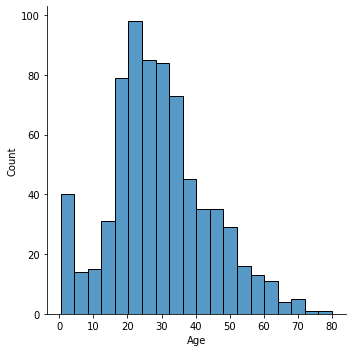

In [5]:
import seaborn as sns
%matplotlib inline

sns.displot(df, x='Age')

The distribution is positive skew, so it's better to use median to imputation.

In [6]:
# age column imputation
df['Age'].fillna(df['Age'].median(), inplace=True)

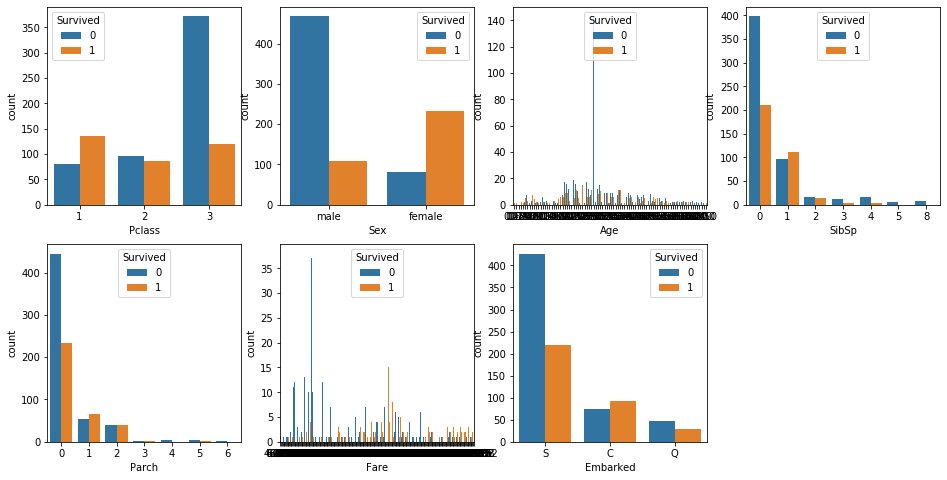

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
title = df.columns[1:].to_list()
for i in range(7):
    plt.subplot(2,4,i+1)
    sns.countplot(x=title[i], hue='Survived', data=df)

From this point, we can make another assumption

- Based on passenger's sex, male is likely to die and female is likely to survive.
- Passenger with passenger class 3 is likely to die, but we cannot make assumption on another classes.
- Passenger with no sibling or spouse is likely to die than passenger who have sibling or spouse.
- Passenger with parent and children have the same condition.
- Passenger who embarked from Southampton is more likely to die (I don't know why?).

More details on Age and Fare

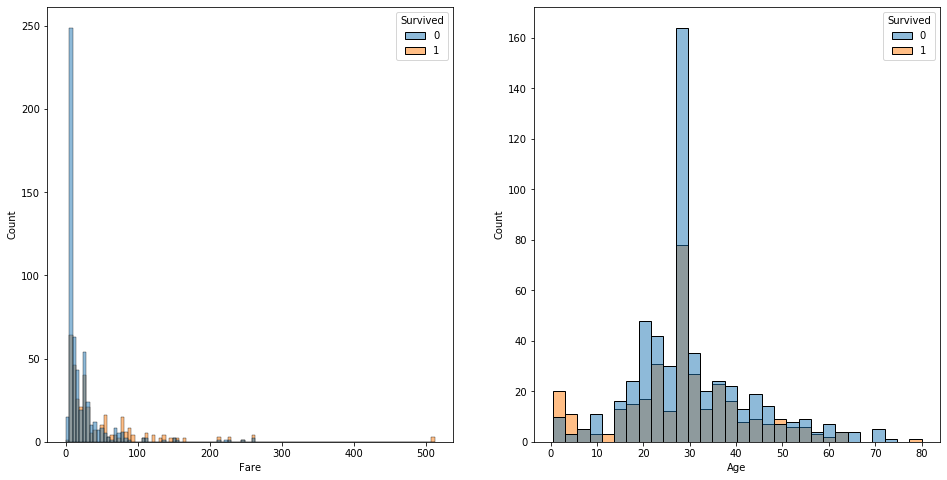

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.histplot(df, x='Fare', hue='Survived')

plt.subplot(1,2,2)
sns.histplot(df, x='Age', hue='Survived')

### Feature Engineering and Selection

In [9]:
df['sex_male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['sex_female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df.drop('Sex', axis=1, inplace=True)

In [10]:
df['embarked_S'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df['embarked_C'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df['embarked_Q'] = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df.drop('Embarked', axis=1, inplace=True)

In [11]:
df_ = pd.read_csv('../data/test.csv')
df_['sex_male'] = df_['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_['sex_female'] = df_['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df_.drop('Sex', axis=1, inplace=True)

In [12]:
df_['embarked_S'] = df_['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df_['embarked_C'] = df_['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df_['embarked_Q'] = df_['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df_.drop('Embarked', axis=1, inplace=True)

In [13]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,sex_male,sex_female,embarked_S,embarked_C,embarked_Q
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,0,0
2,1,1,38.0,1,0,71.2833,0,1,0,1,0
3,1,3,26.0,0,0,7.9250,0,1,1,0,0
4,1,1,35.0,1,0,53.1000,0,1,1,0,0
5,0,3,35.0,0,0,8.0500,1,0,1,0,0


### Modeling
#### Benchmark: predict all dead or all survived

The simplest strategy to get a benchmark score. In the next modeling which should be more complex, the score have to be higher than benchmark.

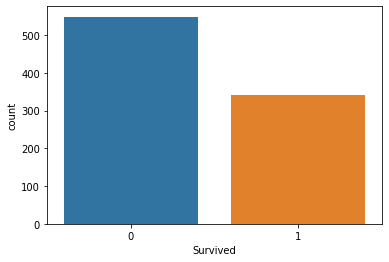

In [14]:
sns.countplot(x='Survived', data=df)

Since died is the majority, I will submit all died for benchmark.

In [15]:
df_test = pd.read_csv('../data/test.csv')
mod1 = df_test.copy()
mod1['Survived'] = 0
mod1 = mod1.loc[:,['PassengerId', 'Survived']]

In [16]:
# I got this data submission with 100% accuracy from kaggle
df_score = pd.read_csv('../data/sub_titanic.csv')

In [17]:
acc = mod1.merge(df_score, how='inner', on='PassengerId')
acc['score'] = acc.apply(lambda x: 1 if x['Survived_x'] == x['Survived_y'] else 0, axis=1)
print('Benchmark score:')
acc['score'].sum()/acc['score'].count()*100

Benchmark score:


62.20095693779905

I got model accuracy 62% just by submitting all passenger die.

#### One-variable Decision Tree (Gender only)

In [18]:
X_test = df_.copy()
mod2 = df_test.copy()
mod2['Survived'] = mod2.apply(lambda x: 0 if x['Sex'] == 'male' else 1, axis=1)
mod2 = mod2.loc[:,['PassengerId', 'Survived']]

In [19]:
acc = mod2.merge(df_score, how='inner', on='PassengerId')
acc['score'] = acc.apply(lambda x: 1 if x['Survived_x'] == x['Survived_y'] else 0, axis=1)
print('Benchmark score:')
acc['score'].sum()/acc['score'].count()*100

Benchmark score:


76.55502392344498

#### Decision Tree

In [20]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

feature = ['sex_male', 'sex_female']

X_train = df.loc[:, feature].values
y_train = df.loc[:, 'Survived'].values
X_test = df_.loc[:, feature].values
y_test = df_score.loc[:, 'Survived'].values

In [21]:
# Train the model
clf = clf.fit(X_train, y_train)

# predict
clf.predict(X_test)

# scoring
print('Decision Tree Score:')
clf.score(X_test, y_test)*100

Decision Tree Score:


76.55502392344498

Decision tree model and if-else model with one feature (gender) have the same score. I need to improve the score in next trial with more feature. First, let's evaluate with confussion metrics.

#### Evaluation

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, log_loss

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_proba_train = clf.predict_proba(X_train)[:,1] # hasilnya berupa probability
y_proba_test = clf.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [23]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [24]:
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [25]:
accuracy_train, accuracy_test = ((tp_train + tn_train)/(tp_train + tn_train + fp_train + fn_train)), ((tp_test + tn_test)/(tp_test + tn_test + fp_test + fn_test))

recall_train, recall_test = (tp_train/(tp_train + fp_train)), (tp_test/(tp_test + fp_test))

specificity_train, specificity_test = (tn_train/(tn_train + fn_train)), (tn_test/(tn_test + fn_test))

precision_train, precision_test = (tp_train/(tp_train + fn_train)), (tp_test/(tp_test + fn_test))

f1_score_train, f1_score_test = (2 * (precision_train * recall_train)/(precision_train + recall_train)), (2 * (precision_test * recall_test)/(precision_test + recall_test))


Train Confusion Matrix
[[468  81]
 [109 233]]
Test Confusion Matrix
[[214  46]
 [ 52 106]]

Area Under Curve
AUC train & test        : 76.69% & 74.70%

Confusion Matrix Evaluation
Accuracy train & test   : 78.68% & 76.56%
Recall train & test     : 68.13% & 67.09%
Specificity train & test: 85.25% & 82.31%
Precision train & test  : 74.20% & 69.74%
F1 Score train & test   : 71.04% & 68.39%
Log Loss train & test   : 7.3652 & 8.0977


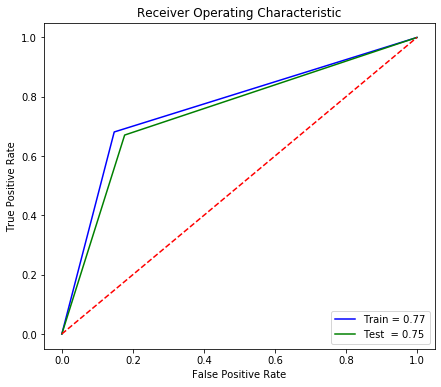

In [26]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Specificity train & test: %.2f%%' % (specificity_train * 100), '&', '%.2f%%' % (specificity_test * 100))
print('Precision train & test  : %.2f%%' % (precision_train * 100), '&', '%.2f%%' % (precision_test * 100))
print('F1 Score train & test   : %.2f%%' % (f1_score_train * 100), '&', '%.2f%%' % (f1_score_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Decision Tree 2

In [27]:
clf = tree.DecisionTreeClassifier()

feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']

X_train = df.loc[:, feature].values
y_train = df.loc[:, 'Survived'].values
X_test = df_.loc[:, feature].values
y_test = df_score.loc[:, 'Survived'].values

In [28]:
# Train the model
clf = clf.fit(X_train, y_train)

# predict
clf.predict(X_test)

# scoring
print('Decision Tree Score:')
clf.score(X_test, y_test)*100

Decision Tree Score:


75.83732057416267

Decision tree model with more feature produce a lower score. This implies that I just added bad features. But let's confirm this with confussion metrics.

#### Evaluation

In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, log_loss

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_proba_train = clf.predict_proba(X_train)[:,1] # hasilnya berupa probability
y_proba_test = clf.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [30]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [31]:
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [32]:
accuracy_train, accuracy_test = ((tp_train + tn_train)/(tp_train + tn_train + fp_train + fn_train)), ((tp_test + tn_test)/(tp_test + tn_test + fp_test + fn_test))

recall_train, recall_test = (tp_train/(tp_train + fp_train)), (tp_test/(tp_test + fp_test))

specificity_train, specificity_test = (tn_train/(tn_train + fn_train)), (tn_test/(tn_test + fn_test))

precision_train, precision_test = (tp_train/(tp_train + fn_train)), (tp_test/(tp_test + fn_test))

f1_score_train, f1_score_test = (2 * (precision_train * recall_train)/(precision_train + recall_train)), (2 * (precision_test * recall_test)/(precision_test + recall_test))


Train Confusion Matrix
[[519  30]
 [115 227]]
Test Confusion Matrix
[[222  38]
 [ 63  95]]

Area Under Curve
AUC train & test        : 89.71% & 81.51%

Confusion Matrix Evaluation
Accuracy train & test   : 83.73% & 75.84%
Recall train & test     : 66.37% & 60.13%
Specificity train & test: 94.54% & 85.38%
Precision train & test  : 88.33% & 71.43%
F1 Score train & test   : 75.79% & 65.29%
Log Loss train & test   : 5.6208 & 8.3456


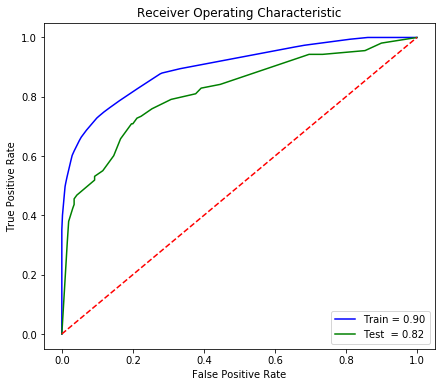

In [33]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Specificity train & test: %.2f%%' % (specificity_train * 100), '&', '%.2f%%' % (specificity_test * 100))
print('Precision train & test  : %.2f%%' % (precision_train * 100), '&', '%.2f%%' % (precision_test * 100))
print('F1 Score train & test   : %.2f%%' % (f1_score_train * 100), '&', '%.2f%%' % (f1_score_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This AUROC show us that added those feature is not a bad decision. But from the AUROC implies the model tend to be overfit.

#### Hyperparameter Tuning

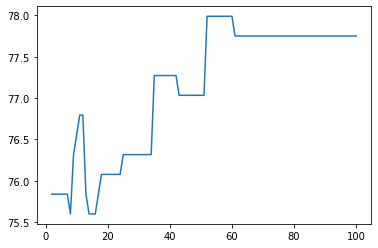

In [34]:
# min_samples_split tuning
X = range(2,101)
Y = []

for i in X:
    clf = tree.DecisionTreeClassifier(min_samples_split=i)
    
    feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']
    
    X_train = df.loc[:, feature].values
    y_train = df.loc[:, 'Survived'].values
    X_test = df_.loc[:, feature].values
    y_test = df_score.loc[:, 'Survived'].values
    
    clf = clf.fit(X_train, y_train)
    clf.predict(X_test)
    
    Y.append(clf.score(X_test, y_test)*100)
    
sns.lineplot(x=X, y=Y)

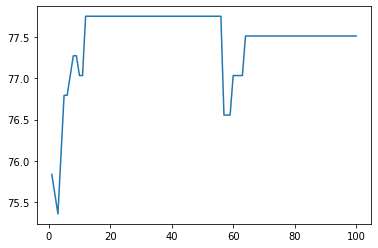

In [35]:
# min_samples_leaf tuning
X = range(1,101)
Y = []

for i in X:
    clf = tree.DecisionTreeClassifier(min_samples_leaf=i)
    
    feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']
    
    X_train = df.loc[:, feature].values
    y_train = df.loc[:, 'Survived'].values
    X_test = df_.loc[:, feature].values
    y_test = df_score.loc[:, 'Survived'].values
    
    clf = clf.fit(X_train, y_train)
    clf.predict(X_test)
    
    Y.append(clf.score(X_test, y_test)*100)
    
sns.lineplot(x=X, y=Y)

In [36]:
# Apply the tuning

clf = tree.DecisionTreeClassifier(min_samples_split=60, min_samples_leaf=20)

feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']

X_train = df.loc[:, feature].values
y_train = df.loc[:, 'Survived'].values
X_test = df_.loc[:, feature].values
y_test = df_score.loc[:, 'Survived'].values

In [37]:
# Train the model
clf = clf.fit(X_train, y_train)

# predict
clf.predict(X_test)

# scoring
print('Decision Tree Score:')
clf.score(X_test, y_test)*100

Decision Tree Score:


77.75119617224881

In [38]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_proba_train = clf.predict_proba(X_train)[:,1] # hasilnya berupa probability
y_proba_test = clf.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [39]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [40]:
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [41]:
accuracy_train, accuracy_test = ((tp_train + tn_train)/(tp_train + tn_train + fp_train + fn_train)), ((tp_test + tn_test)/(tp_test + tn_test + fp_test + fn_test))

recall_train, recall_test = (tp_train/(tp_train + fp_train)), (tp_test/(tp_test + fp_test))

specificity_train, specificity_test = (tn_train/(tn_train + fn_train)), (tn_test/(tn_test + fn_test))

precision_train, precision_test = (tp_train/(tp_train + fn_train)), (tp_test/(tp_test + fn_test))

f1_score_train, f1_score_test = (2 * (precision_train * recall_train)/(precision_train + recall_train)), (2 * (precision_test * recall_test)/(precision_test + recall_test))


Train Confusion Matrix
[[523  26]
 [142 200]]
Test Confusion Matrix
[[237  23]
 [ 70  88]]

Area Under Curve
AUC train & test        : 86.71% & 82.08%

Confusion Matrix Evaluation
Accuracy train & test   : 81.14% & 77.75%
Recall train & test     : 58.48% & 55.70%
Specificity train & test: 95.26% & 91.15%
Precision train & test  : 88.50% & 79.28%
F1 Score train & test   : 70.42% & 65.43%
Log Loss train & test   : 6.5124 & 7.6845


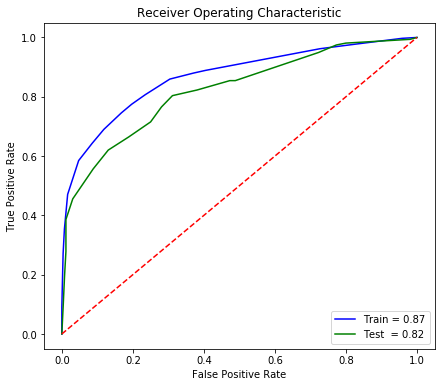

In [42]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Specificity train & test: %.2f%%' % (specificity_train * 100), '&', '%.2f%%' % (specificity_test * 100))
print('Precision train & test  : %.2f%%' % (precision_train * 100), '&', '%.2f%%' % (precision_test * 100))
print('F1 Score train & test   : %.2f%%' % (f1_score_train * 100), '&', '%.2f%%' % (f1_score_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000)

# Train the model
rf.fit(X_train, y_train)

# predict
rf.predict(X_test)

# scoring
print('Random Forest Score:')
rf.score(X_test, y_test)*100

Random Forest Score:


77.03349282296651

The random forest model performed better but had less impact.

#### Model Evaluation

In [44]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
y_proba_train = rf.predict_proba(X_train)[:,1] # hasilnya berupa probability
y_proba_test = rf.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [45]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [46]:
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [47]:
accuracy_train, accuracy_test = ((tp_train + tn_train)/(tp_train + tn_train + fp_train + fn_train)), ((tp_test + tn_test)/(tp_test + tn_test + fp_test + fn_test))

recall_train, recall_test = (tp_train/(tp_train + fp_train)), (tp_test/(tp_test + fp_test))

specificity_train, specificity_test = (tn_train/(tn_train + fn_train)), (tn_test/(tn_test + fn_test))

precision_train, precision_test = (tp_train/(tp_train + fn_train)), (tp_test/(tp_test + fn_test))

f1_score_train, f1_score_test = (2 * (precision_train * recall_train)/(precision_train + recall_train)), (2 * (precision_test * recall_test)/(precision_test + recall_test))


Train Confusion Matrix
[[516  33]
 [112 230]]
Test Confusion Matrix
[[222  38]
 [ 58 100]]

Area Under Curve
AUC train & test        : 89.40% & 82.01%

Confusion Matrix Evaluation
Accuracy train & test   : 83.73% & 77.03%
Recall train & test     : 67.25% & 63.29%
Specificity train & test: 93.99% & 85.38%
Precision train & test  : 87.45% & 72.46%
F1 Score train & test   : 76.03% & 67.57%
Log Loss train & test   : 5.6208 & 7.9324


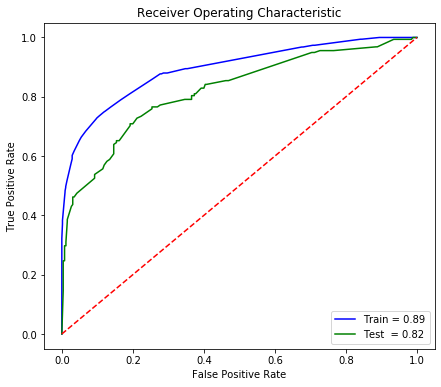

In [48]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Specificity train & test: %.2f%%' % (specificity_train * 100), '&', '%.2f%%' % (specificity_test * 100))
print('Precision train & test  : %.2f%%' % (precision_train * 100), '&', '%.2f%%' % (precision_test * 100))
print('F1 Score train & test   : %.2f%%' % (f1_score_train * 100), '&', '%.2f%%' % (f1_score_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

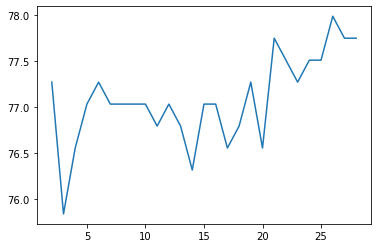

In [54]:
# min_samples_split tuning
X = range(2,35)
Y = []

for i in X:
    rf = RandomForestClassifier(min_samples_split = i)
    
    feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']
    
    X_train = df.loc[:, feature].values
    y_train = df.loc[:, 'Survived'].values
    X_test = df_.loc[:, feature].values
    y_test = df_score.loc[:, 'Survived'].values
    
    rf = rf.fit(X_train, y_train)
    rf.predict(X_test)
    
    Y.append(rf.score(X_test, y_test)*100)
    
sns.lineplot(x=X, y=Y)

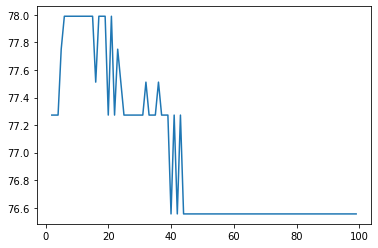

In [61]:
# min_samples_leaf tuning
X = range(2,100)
Y = []

for i in X:
    rf = RandomForestClassifier(min_samples_leaf = i)
    
    feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']
    
    X_train = df.loc[:, feature].values
    y_train = df.loc[:, 'Survived'].values
    X_test = df_.loc[:, feature].values
    y_test = df_score.loc[:, 'Survived'].values
    
    rf = rf.fit(X_train, y_train)
    rf.predict(X_test)
    
    Y.append(rf.score(X_test, y_test)*100)
    
sns.lineplot(x=X, y=Y)

In [62]:
# Apply the tuning

rf = RandomForestClassifier(n_estimators = 1000, min_samples_split = 26, min_samples_leaf = 10)

# Train the model
rf.fit(X_train, y_train)

# predict
rf.predict(X_test)

# scoring
print('Random Forest Score:')
rf.score(X_test, y_test)*100

Random Forest Score:


77.99043062200957

In [63]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
y_proba_train = rf.predict_proba(X_train)[:,1] # hasilnya berupa probability
y_proba_test = rf.predict_proba(X_test)[:,1]
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [64]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [65]:
tp_train, tp_test = cm_train[1][1], cm_test[1][1]
tn_train, tn_test = cm_train[0][0], cm_test[0][0]
fp_train, fp_test = cm_train[1][0], cm_test[1][0]
fn_train, fn_test = cm_train[0][1], cm_test[0][1]

In [66]:
accuracy_train, accuracy_test = ((tp_train + tn_train)/(tp_train + tn_train + fp_train + fn_train)), ((tp_test + tn_test)/(tp_test + tn_test + fp_test + fn_test))

recall_train, recall_test = (tp_train/(tp_train + fp_train)), (tp_test/(tp_test + fp_test))

specificity_train, specificity_test = (tn_train/(tn_train + fn_train)), (tn_test/(tn_test + fn_test))

precision_train, precision_test = (tp_train/(tp_train + fn_train)), (tp_test/(tp_test + fn_test))

f1_score_train, f1_score_test = (2 * (precision_train * recall_train)/(precision_train + recall_train)), (2 * (precision_test * recall_test)/(precision_test + recall_test))


Train Confusion Matrix
[[522  27]
 [139 203]]
Test Confusion Matrix
[[237  23]
 [ 69  89]]

Area Under Curve
AUC train & test        : 86.47% & 81.17%

Confusion Matrix Evaluation
Accuracy train & test   : 81.37% & 77.99%
Recall train & test     : 59.36% & 56.33%
Specificity train & test: 95.08% & 91.15%
Precision train & test  : 88.26% & 79.46%
F1 Score train & test   : 70.98% & 65.93%
Log Loss train & test   : 6.4349 & 7.6019


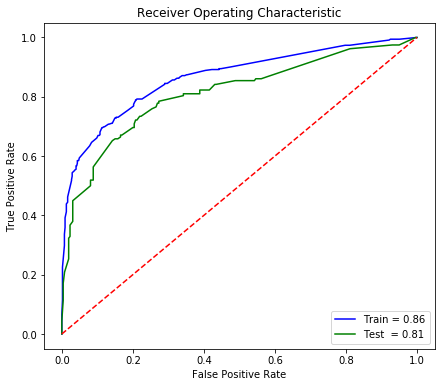

In [67]:
# Print all the evaluation metrics
print('\nTrain Confusion Matrix')
print(cm_train)
print('Test Confusion Matrix')
print(cm_test)
print('\nArea Under Curve')
print('AUC train & test        : %.2f%%' % (roc_auc_train * 100), '&', '%.2f%%' % (roc_auc_test * 100))
print('\nConfusion Matrix Evaluation')
print('Accuracy train & test   : %.2f%%' % (accuracy_train * 100), '&', '%.2f%%' % (accuracy_test * 100))
print('Recall train & test     : %.2f%%' % (recall_train * 100), '&', '%.2f%%' % (recall_test * 100))
print('Specificity train & test: %.2f%%' % (specificity_train * 100), '&', '%.2f%%' % (specificity_test * 100))
print('Precision train & test  : %.2f%%' % (precision_train * 100), '&', '%.2f%%' % (precision_test * 100))
print('F1 Score train & test   : %.2f%%' % (f1_score_train * 100), '&', '%.2f%%' % (f1_score_test * 100))
print('Log Loss train & test   :', round(log_loss(y_train, y_pred_train), 4), '&',
          round(log_loss(y_test, y_pred_test), 4))

#create plot of ROC_AUC
plt.figure(figsize=(7, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label='Train = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'g', label='Test  = %0.2f' % roc_auc_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()